# Neural Network for solving FBSDEs

By using Ito Lemma, we set $Y_{t}=u\left(t, X_{t}\right), \text { and } Z_{t}=D u\left(t, X_{t}\right)$. We proceed by approximating the unknown solution $u(t; x)$ by a deep neural network. We obtain the required gradient vector $Du(t; x)$ by applying the chain rule for differentiating compositions of
functions using automatic differentiation. 

Parameters of the neural network representing $u(t; x)$ can be learned by minimizing the following loss function given explicitly in equation obtained
from discretizing the above forward-backward stochastic differential equation 
using the standard Euler-Maruyama scheme.

Here we consider Hamilton-Jacobi-Bellman Equation, and obtain:
\begin{aligned}
&X^{n+1} = X^n+\sigma ΔW^n  \\
&Y^{n+1} \approx Y^{n}+ \left\|Z^n\right\|^{2} \Delta t^{n}+ \sigma Z^n \Delta W^{n}
\end{aligned}
for $n=0,1, \ldots, N-1$. 

The loss function is then give by 
$\sum_{m=1}^{M} \sum_{n=0}^{N-1}\left|Y_{m}^{n+1}-Y_{m}^{n}-\Phi_{m}^{n} \Delta t^{n}-\left(Z_{m}^{n}\right) \Sigma_{m}^{n} \Delta W_{m}^{n}\right|^{2}+\sum_{m=1}^{M}\left|Y_{m}^{N}-g\left(X_{m}^{N}\right)\right|^{2}+\sum_{m=1}^{M}\left|Z_{m}^{N}-Dg\left(X_{m}^{N}\right)\right|^{2}$

where $\Phi_{m}^{n}:=r\left(Y^n_m-Z^n_m X^n_m\right)$ and $\Sigma_m^n=\sigma X^n_m$. The subscript m corresponds to the m-th realization of the underlying Brownian motion while the superscript n corresponds to time $t^n$.


In [1]:
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torch import nn
import time

To further verify our model, we use the explicit solution of this equation
\begin{aligned}
u(t, x)=\exp \left(\left(r+\sigma^{2}\right)(T-t)\right) g(x)
\end{aligned}
where $g(x)$ is the terminal condition $u(T,x)$

In [5]:
T=1 #terminal time
M=128  #number of trajectoris
N=50   #number of time step
D=10
Xi=np.array([1.0,0.5]*int(D/2))[None,:]  #initial X0

layers=[D+1]+5*[256]+[1]  #NN layers
learning_rate=1e-5
sigma=0.4
r = 0.05
epoch=10
NIter=2000  #number of iteration

In [6]:
from fbsde_nn import toy_example1
myFBSDE=toy_example1(Xi,T,M,N,D,layers,learning_rate, r, sigma)

In [7]:
myFBSDE.train(NIter, epoch)

Epoch 1
-------------------------------
Batch 1, Loss: 7726.2431640625, Time: 2.20s
Batch 1001, Loss: 171.90000915527344, Time: 92.83s
Epoch 2
-------------------------------
Batch 1, Loss: 49.052345275878906, Time: 180.11s
Batch 1001, Loss: 28.63874626159668, Time: 266.64s
Epoch 3
-------------------------------
Batch 1, Loss: 12.833832740783691, Time: 353.57s
Batch 1001, Loss: 8.29752254486084, Time: 440.24s
Epoch 4
-------------------------------
Batch 1, Loss: 10.081216812133789, Time: 527.32s
Batch 1001, Loss: 3.0103566646575928, Time: 614.39s
Epoch 5
-------------------------------
Batch 1, Loss: 3.8747129440307617, Time: 701.52s
Batch 1001, Loss: 2.3884453773498535, Time: 788.49s
Epoch 6
-------------------------------
Batch 1, Loss: 2.6880736351013184, Time: 875.61s
Batch 1001, Loss: 2.2469258308410645, Time: 962.87s
Epoch 7
-------------------------------
Batch 1, Loss: 2.2941932678222656, Time: 1049.78s
Batch 1001, Loss: 1.8191951513290405, Time: 1136.32s
Epoch 8
------------

In [8]:
K=10
Y_star_path, Y_real=myFBSDE.predict(Xi,K)

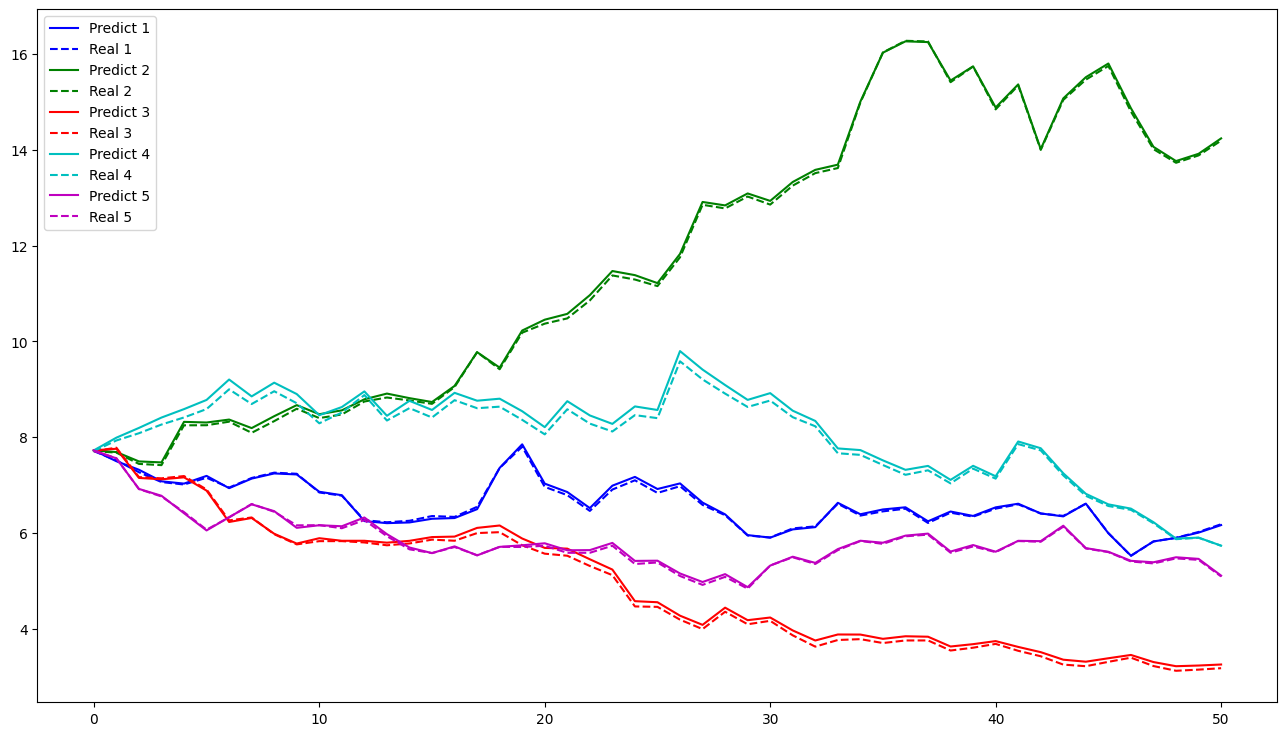

In [9]:
colour=['b','g','r','c','m','y','k','w','mediumseagreen','aquamarine']
Y_star_path=Y_star_path.cpu()
Y_real=Y_real.cpu()


Y_star_path=Y_star_path.detach().numpy()
Y_real=Y_real.detach().numpy()

Y_star_path=Y_star_path.squeeze()
Y_real=Y_real.squeeze()

plt.figure(figsize=(16,9))
for i in range(5):
    plt.plot(Y_star_path[i,:],color=colour[i],label=f'Predict {i+1}')
    plt.plot(Y_real[i,:],linestyle='dashed',color=colour[i],label=f'Real {i+1}')
    
plt.legend()

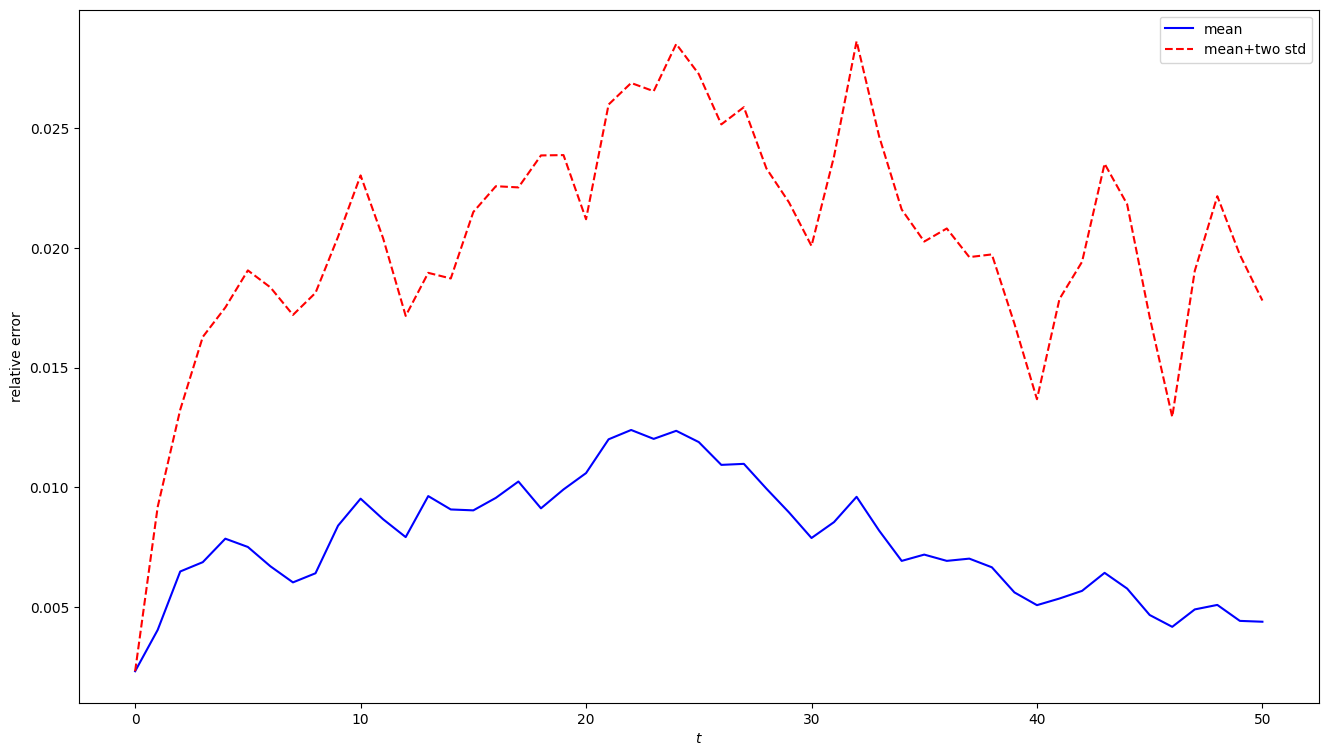

In [10]:
error=np.sqrt((Y_real-Y_star_path)**2/Y_real**2+1e-6)

mean_errors=np.mean(error,0)
std_error=np.std(error,0)
plt.figure(figsize=(16,9))
plt.plot(mean_errors,'b',label='mean')
plt.plot(mean_errors+2*std_error,'r--',label='mean+two std')
plt.xlabel('$t$')
plt.ylabel('relative error')
plt.legend()